In [1]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix, adjusted_rand_score

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stopwords = []


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Stopwords
def load_stopwords():
    with open('Stopword-List.txt', 'r') as f:
        for line in f:
            # if line is space, skip
            if not line.strip():
                continue
            stopwords.append(line.strip())
load_stopwords()


In [3]:
# Preprocess

def preprocessing(corpus):
    # lowercase
    corpus = corpus.lower()
    # remove punctuation
    corpus = re.sub(r'[^\w\s]', '', corpus)
    # remove numbers
    corpus = re.sub(r'\d+', '', corpus)
    # replace multiple spaces with single space
    corpus = re.sub(r'\s+', ' ', corpus)
    # remove leading and trailing spaces
    corpus = corpus.strip()
    # remove irrelevant characters
    corpus = re.sub(r'[^\x00-\x7F]+', '', corpus)
    tokens = word_tokenize(corpus)
    # remove stopwords and stem
    tokens = [ps.stem(token) for token in tokens if token not in stopwords]
    # remove single character tokens
    tokens = [token for token in tokens if len(token) > 1]
    # remove large tokens
    tokens = [token for token in tokens if len(token) < 20]
    # remove tokens with consecutive characters
    tokens = [token for token in tokens if not re.match(
        r".*(.)\1{2,}.*", token)]
    # remove urls with http or https using startswith
    tokens = [token for token in tokens if not token.startswith(
        'http') and not token.startswith('https')]
    # http or https in the middle of the url
    tokens = [token for token in tokens if not re.match(
        r"[a-zA-Z0-9\./]+http[a-zA-Z0-9\./]+", token)]
    # remove url with github
    tokens = [token for token in tokens if not re.match(
        r"github/[a-zA-Z0-9\./]+", token)]
    # remove email addresses using regex
    tokens = [token for token in tokens if not re.match(
        r"[^@]+@[^@]+\.[^@]+", token)]
    return tokens

In [4]:
def load_data():
    data = []
    index = []
    for filename in sorted(os.listdir(r'ResearchPapers'), key=lambda x: int(x[:-4])):
        with open(r'ResearchPapers/' + filename, 'r') as f:
            filename = int(filename[:-4])
            index.append(filename)
            data.append(f.read())
    return data, index

data,index = load_data()

In [5]:
df = pd.DataFrame(index=index)
df['data'] = data
df['data'] = df['data'].apply(preprocessing)
df['data'] = df['data'].apply(lambda x: ' '.join(x))


In [6]:
for i in df.index:
    if i == 1 or i == 2 or i == 3 or i == 7:
        df.at[i, 'gt_label'] = 0 # Explainable Artificial Intelligence
    elif i == 8 or i == 9 or i == 11:
        df.at[i, 'gt_label'] = 1 # Heart Failure
    elif i == 12 or i == 13 or i == 14 or i == 15 or i == 16:
        df.at[i, 'gt_label'] = 2 # "Time Series Forecasting"
    elif i == 17 or i == 18 or i == 21:
        df.at[i, 'gt_label'] = 3 # "Transformer Model"
    elif i == 22 or i == 23 or i == 24 or i == 25 or i == 26:
        df.at[i, 'gt_label'] = 4 # "Feature Selection"

df['gt_label'] = df['gt_label'].astype(int)

In [7]:
# TF-IDF
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['data'])
X = X.toarray()


In [8]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df['cluster'] = labels

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]
df['pca3'] = X_pca[:, 2]

In [9]:
def purity_score(y_true, y_pred):
   # Build confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    # Return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

true_labels = df['gt_label']
cluster_labels = df['cluster']

purity = purity_score(true_labels, cluster_labels)
silhouette = silhouette_score(X, cluster_labels)
random_index = adjusted_rand_score(true_labels, cluster_labels)

print("Silhouette Score:", silhouette)
print("Purity Score:", purity)
print("Random Index:",random_index)

Silhouette Score: 0.3039349311088105
Purity Score: 0.85
Random Index: 0.7283126787416587


Cluster: Silhouette Score, Rand Index
k=2: 0.13761420849511496, 0.2333495381623724
k=3: 0.18408548164734512, 0.44305850068604213
k=4: 0.21395813317181225, 0.7625395767372105
k=5: 0.3039349311088105, 0.7283126787416587
k=6: 0.3113662707174595, 0.7302231237322515
k=7: 0.3034454362529324, 0.7563061137238136
k=8: 0.29203064720026684, 0.7853592408495256
k=9: 0.28167529119639506, 0.6906976744186046


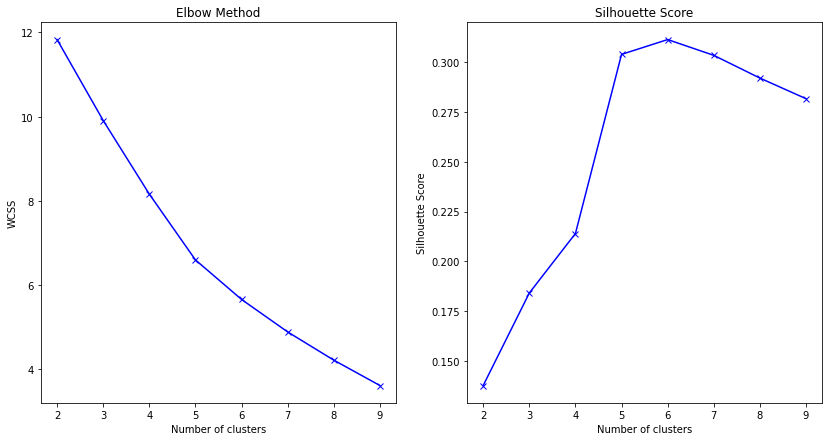

In [10]:
wcss = []
sil = []
rand = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    rand.append(adjusted_rand_score(true_labels, labels))

print("Cluster: Silhouette Score, Rand Index")
for i in range(len(sil)):
    print(f'k={i+2}: {sil[i]}, {rand[i]}')

fig , ax = plt.subplots(1,2, figsize=(14,7))
ax[0].plot(range(2, 10), wcss, 'bx-')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('WCSS')

ax[1].plot(range(2, 10), sil,'bx-')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')

plt.show()

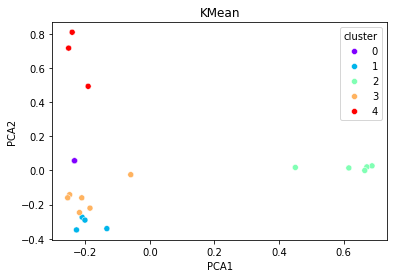

In [11]:
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='rainbow')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('KMean')
plt.show()


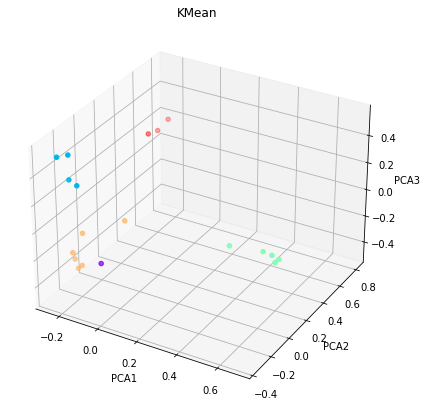

In [12]:
# 3D plot
fig = plt.figure(1, figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['pca1'], df['pca2'], df['pca3'], c=df['cluster'], cmap='rainbow')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('KMean')
plt.show()


In [13]:
for i in range(5):
    print('Cluster:', i)
    print(df[df['cluster'] == i].index)
    print()


Cluster: 0
Int64Index([13, 14], dtype='int64')

Cluster: 1
Int64Index([1, 2, 3, 7], dtype='int64')

Cluster: 2
Int64Index([22, 23, 24, 25, 26], dtype='int64')

Cluster: 3
Int64Index([12, 15, 16, 17, 18, 21], dtype='int64')

Cluster: 4
Int64Index([8, 9, 11], dtype='int64')

